In [1]:
from general_tools.notebook.gpu_utils import setup_one_gpu
GPU = 1
setup_one_gpu(GPU)

Picking GPU 1


In [2]:
import sys
import numpy as np
import os.path as osp
from tf_lab.iclr.evaluator import Evaluator
from general_tools.in_out.basics import files_in_subdirs
from geo_tool import Point_Cloud
from tf_lab.iclr.helper import stored_synthetic_samples
from tf_lab.evaluate.generative_pc_nets import coverage
from collections import defaultdict
import collections

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
class_name = 'chair'
boost_samples = 3

In [5]:
best_by_jsd = {'r_gan': 1700,
               'l_gan_chamfer': 300,
               'l_gan_emd': 100
              }

In [6]:
evaluator = Evaluator(class_name)
evaluator.load_gt_data()

In [7]:
corr_stats = collections.namedtuple('corr_stats', 'samples matched_id matched_dist');

In [8]:
split = 'val'
gt_data = evaluator.gt_data[split].copy()
chamfer_correspondences = defaultdict(corr_stats)

for model_name in best_by_jsd:
    print model_name    
    top_sample_dir = stored_synthetic_samples(class_name)[model_name]    
    
    if 'gan' in model_name:
        epoch = best_by_jsd[model_name]
        sample_file = osp.join(top_sample_dir, 'epoch_%d.npz' % (epoch,))
    elif 'gmm' in experiment_name:
        gaussian_type = best_by_jsd[model_name]
        sample_file = osp.join(top_sample_dir, gaussian_type + '.npz')
    else:
        assert False

    evaluator.prepare_sample_data(sample_file, boost_samples)
    samples_to_cmp = evaluator.sample_data[split].copy()    
    n_samples = len(samples_to_cmp)
    batch_size = n_samples
        
    mathed_idx, matched_dists = coverage(gt_data, samples_to_cmp, 
             batch_size=batch_size, normalize= True, 
             use_EMD=False, ret_dist=True)

    mathed_idx = np.array(mathed_idx)
    matched_dists = np.array(matched_dists)
    chamfer_correspondences[model_name] = corr_stats(samples_to_cmp, mathed_idx, matched_dists)

l_gan_chamfer
r_gan
l_gan_emd


In [90]:
r_gan_winners = [] # holds gt ids
r_winning_samples = []
r_ch_scores = []
emd_lossing_samples = []
emd_ch_scores = []

for i in range(len(gt_data)):
    if chamfer_correspondences['r_gan'].matched_dist[i] < chamfer_correspondences['l_gan_emd'].matched_dist[i]:
#     if chamfer_correspondences['r_gan'].matched_dist[i] < chamfer_correspondences['l_gan_chamfer'].matched_dist[i]:
        r_gan_winners.append(i)
        mi = chamfer_correspondences['r_gan'].matched_id[i]
        r_winning_samples.append(chamfer_correspondences['r_gan'].samples[mi])
        r_ch_scores.append(chamfer_correspondences['r_gan'].matched_dist[i])
        
        mi = chamfer_correspondences['l_gan_emd'].matched_id[i]
        emd_lossing_samples.append(chamfer_correspondences['l_gan_emd'].samples[mi])
        emd_ch_scores.append(chamfer_correspondences['l_gan_emd'].matched_dist[i])
        

r_winning_samples = np.array(r_winning_samples)
r_ch_scores = np.array(r_ch_scores)
emd_lossing_samples = np.array(emd_lossing_samples)
emd_ch_scores = np.array(emd_ch_scores)

In [92]:
gt_samples_ = gt_data[r_gan_winners]

In [22]:
from general_tools.simpletons import iterate_in_chunks
from tf_lab.external.Chamfer_EMD_losses.tf_approxmatch import approx_match, match_cost
import tensorflow as tf    

def compute_emd_loss(pc1, pc2, batch_size):
    ''' normalize (boolean): if True the Chamfer distance between two point-clouds is the average of matched
                             point-distances. Alternatively, is their sum.
    '''
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    sess = tf.Session(config=config)
    
    n_ref, n_pc_points, pc_dim = pc1.shape
    _, n_pc_points_s, pc_dim_s = pc2.shape
    
    # TF Graph Operations
    ref_pl = tf.placeholder(tf.float32, shape=(None, n_pc_points, 3))
    sample_pl = tf.placeholder(tf.float32, shape=(None, n_pc_points, 3))
    match = approx_match(ref_pl, sample_pl)
    all_dist_in_batch = match_cost(ref_pl, sample_pl, match)
    
    all_dists = []
    for chunk in iterate_in_chunks(np.arange(n_ref), batch_size):
        feed_dict = {ref_pl: pc1[chunk], sample_pl: pc2[chunk]}
        b = sess.run(all_dist_in_batch, feed_dict=feed_dict)
        all_dists.append(b)
    sess.close()
    return np.array(all_dists)[0]

In [93]:
r_emd_scores = compute_emd_loss(gt_samples_, r_winning_samples, 450) / float(2048)
l_emd_scores = compute_emd_loss(gt_samples_, emd_lossing_samples, 450) / float(2048)

In [94]:
np.sum(r_emd_scores < l_emd_scores) / float(len(r_gan_winners))

0.030534351145038167

In [78]:
import matplotlib.pylab as plt
from general_tools.in_out.basics import create_dir

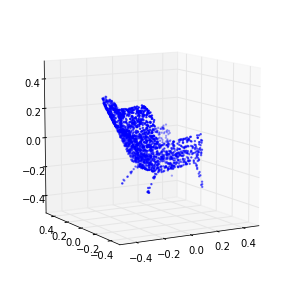

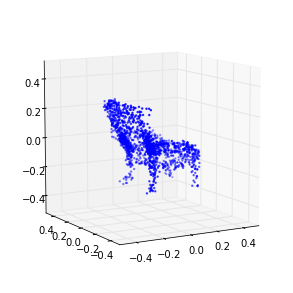

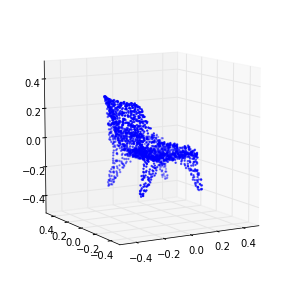

In [122]:
top_out_dir = '/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/iclr/demonstrations/chamfer_weakness_hot_spots/l_gan_emd'
create_dir(top_out_dir)
azim = 240
show = True

emd_based_exampled = [np.random.randint(len(gt_samples_))]

for i in emd_based_exampled:
    if r_emd_scores[i] > l_emd_scores[i]:
        out_dir = osp.join(top_out_dir, str(i))
        create_dir(out_dir)
        out_f = osp.join(out_dir, 'gt')
        fig = Point_Cloud(gt_samples_[i]).plot(show=show, azim=azim)
        fig.savefig(out_f)
        plt.close()
        np.savetxt(out_f + '.txt', gt_samples_[i])
        
        out_f = osp.join(out_dir, 'raw_gan')
        fig = Point_Cloud(r_winning_samples[i]).plot(show=show, azim=azim)
        fig.savefig(out_f)
        plt.close()
        np.savetxt(out_f + '.txt', r_winning_samples[i])
        
        out_f = osp.join(out_dir, 'l_gan_emd')
        fig = Point_Cloud(emd_lossing_samples[i]).plot(show=show, azim=azim)
        fig.savefig(out_f)
        plt.close()
        np.savetxt(out_f + '.txt', emd_lossing_samples[i])
        
        with open(osp.join(out_dir, 'scores.txt'), 'w') as fout:
            fout.write('Chamfer scores (raw, latent):\n')
            fout.write('%f %f\n' % (r_ch_scores[i], emd_ch_scores[i]))
            fout.write('EMD scores (raw, latent):\n')
            fout.write('%f %f\n' % (r_emd_scores[i], l_emd_scores[i]))

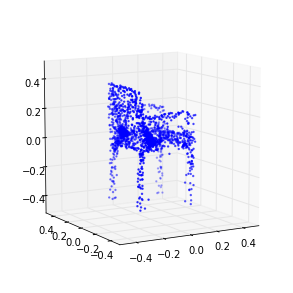

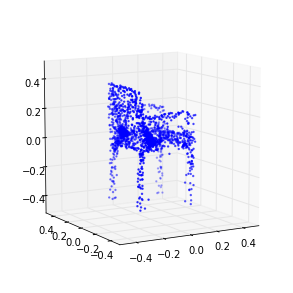

In [128]:
pcf = '/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/iclr/demonstrations/chamfer_weakness_hot_spots/l_gan_emd/113/raw_gan.txt'
pc = np.loadtxt(pcf)
Point_Cloud(pc).plot()